## Importera bibliotek och definiera konstanter

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import linregress

# Konstanter
L   = 0.600           # [m]
m   = 0.100           # [kg]
r   = 3.375e-2        # [m]
A   = np.pi * r ** 2  # [m^2]
rho = 1.184           # [kg/m^3]
eta = 1.806e-5        # [Pa*s]
g   = 9.82            # [m/s^2]

f = 500               # [Hz]
dt = 1 / f            # [s]
MM_TO_M = 1e-3        # [m/s^2]

# OBS: Savitzky-Golay används för att smootha och derivera pendelns läge.
WINDOW_LEN = 51  # Justera om behövs   
POLY_ORDER = 3 
PEAK_DIST = 350       

FILEPATH_INPUT = './../../measurements/pt1/kula2_mätning1.tsv'
FILEPATH_OUTPUT = './../../data_analysis/pt1/regression_data.csv'
WRITE_CSV = False

## Läs fil och utför grundläggande databehandling

In [63]:
# Läs TSV-fil
df = pd.read_csv(
    FILEPATH_INPUT, 
    sep='\t', 
    header=None, 
    skiprows=10, 
    names=['x', 'y', 'z']
)

df = df[1:]

# Inledande databehandling
df[['x', 'y', 'z']] *= MM_TO_M
df['t'] = dt * df.index

## Hitta vändlägen

In [64]:
df['z_smooth'] = savgol_filter(
    df['z'],
    WINDOW_LEN,
    POLY_ORDER,
    deriv=0,
    delta=dt
)
peak_idxs, _ = find_peaks(df['z_smooth'], distance=PEAK_DIST)
peak_idxs = peak_idxs[0::2]

## Hitta x-koordinat för jämvikt och förskjut

In [65]:
mins_idxs, _ = find_peaks(-1 * df['z_smooth'], distance=PEAK_DIST)  # OBS! multiplicera med -1

z_eq = np.mean(df['z'][mins_idxs])
x_eq = np.mean(df['x'][mins_idxs])

df['z_rel'] = df['z'] - z_eq
df['x_rel'] = df['x'] - x_eq

## Beräkna $v(t)$ och $v_{min}$ för $\operatorname{Re} \geq 10^3$

In [66]:
# Beräkna v(t)
vel = savgol_filter(
    df[['x', 'y', 'z']],
    window_length=WINDOW_LEN,
    polyorder=POLY_ORDER,
    deriv=1,                  
    delta=dt,
    axis=0,
)
df['v'] = np.linalg.norm(vel, axis=1)

def v_Re(Re, rho, eta, l):
    """
    Compute the speed corresponding to a given Reynolds number, fluid density, dynamic
    viscosity and characteristic length.
    """
    return Re*eta / (rho*l)

v_min = v_Re(1.0e3, rho, eta, 2*r)

## Plotta $z_{rel}(t)$ och $v(t)$

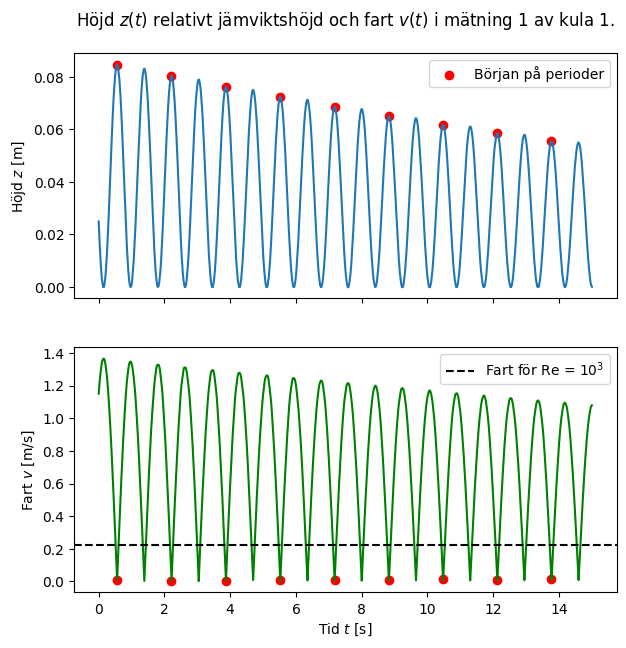

In [67]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 7))

# Plotta z_rel(t)
axs[0].plot(df['t'], df['z_rel'])
axs[0].set_ylabel('Höjd $z$ [m]')
axs[0].scatter(df['t'][peak_idxs], df['z_rel'][peak_idxs], color='red', label='Början på perioder')  # Vändlägena (varannat fr.o.m. det första) 
axs[0].set_title('Höjd $z(t)$ relativt jämviktshöjd och fart $v(t)$ i mätning 1 av kula 1.', pad=20) 
axs[0].legend()

# Jämviktslägena (kan tas bort, för eget bruk)
# axs[0].scatter(df['t'][mins_idxs], df['z_rel'][mins_idxs], color='blue')

# Plotta v(t)
axs[1].plot(df['t'], df['v'], color='green')
axs[1].axhline(v_min, color='black', linestyle='dashed', label=r'Fart för Re = $10^3$')

axs[1].set_xlabel('Tid $t$ [s]')
axs[1].set_ylabel('Fart $v$ [m/s]')
axs[1].legend()
axs[1].scatter(df['t'][peak_idxs], df['v'][peak_idxs], color='red')

# Jämviktslägena (kan tas bort, för eget bruk)
# axs[1].scatter(df['t'][mins_idxs], df['v'][mins_idxs], color='blue')  

## Plotta $\theta(t)$

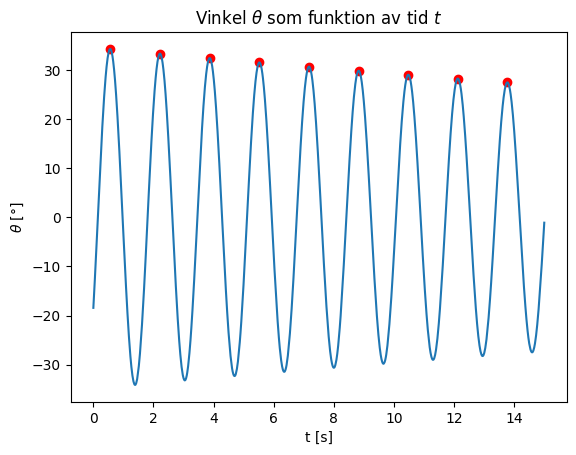

In [68]:
df['th_deg'] = np.degrees(np.arcsin(df['x_rel'] / L))

fig2, ax2 = plt.subplots()
ax2.plot(df['t'], df['th_deg'])

ax2.set_xlabel('t [s]')
ax2.set_ylabel(r'$\theta$ [°]')
ax2.set_title(r'Vinkel $\theta$ som funktion av tid $t$')
ax2.scatter(df['t'][peak_idxs], df['th_deg'][peak_idxs], color='red')

## Karaktärisera mätpunkter efter regim

In [69]:
def v_reynolds(Re, rho, L, eta):
    return Re * eta / (rho * L)

def flow_regime(v):
    v1 = v_reynolds(1, rho, 2*r, eta)    # Fart vid övergång mellan laminärt och övergångsflöde
    v2 = v_reynolds(1e3, rho, 2*r, eta)  # Fart vid övergång mellan övergångs- och turbulent flöde
    v3 = v_reynolds(2e5, rho, 2*r, eta)  # Fart vid övergång mellan turbulent flöde och superkritiskt Re
    
    assert np.all(v <= v3)
    
    regime = np.empty(v.shape, dtype='U12')
    
    regime[v < v1] = 'laminar'
    regime[(v1 <= v) & (v < v2)] = 'transitional'
    regime[v2 <= v] = 'turbulent'
    
    return regime

num_points_turbulent = df[flow_regime(df['v']) == 'turbulent'].shape[0]
num_points = df.shape[0]
frac_turbulent = num_points_turbulent / num_points

print(f'Andel av svängningsrörelsen där strömningen runt kulan är turbulent: {100 * frac_turbulent:.3f}%')

Andel av svängningsrörelsen där strömningen runt kulan är turbulent: 87.878%


## Beräkna luftmotståndskoefficient $C_d$

Experimentell luftmotståndskoefficient: C_d ≈ 0.83
Förklaringsgrad: R^2 ≈ 0.99


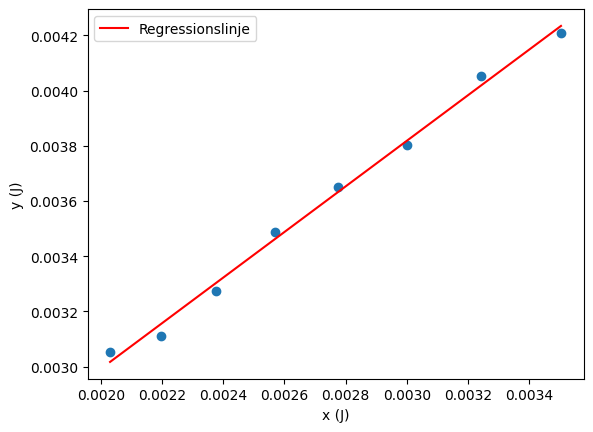

In [70]:
# Höjdminskningar mellan vändlägen
delta_z = -np.diff(df['z_smooth'][peak_idxs])

# Hastighetsintegral mellan vändlägen
vel_int = np.zeros_like(delta_z)

for i in range(len(peak_idxs) - 1):
    i0, i1 = peak_idxs[i], peak_idxs[i + 1]
    v = df['v'].iloc[i0:i1 + 1]
    t = df['t'].iloc[i0:i1 + 1]
    vel_int[i] = trapezoid(v ** 3, dx=dt)

# Linjär regression
y = m * g * delta_z
x = 1/2 * rho * A * vel_int

slope, intercept, r, p, std_err = linregress(x, y)
C_d = slope

# Skriv (x, y) data till CSV-fil (kan tas bort)
if WRITE_CSV:
    df_output = pd.DataFrame({
        'x (J)': x,
        'y (J)': y
    })
    df_output.to_csv(FILEPATH_OUTPUT, mode='a', header=False, index=False)

# Plotta z (kan tas bort)
fig3, ax3 = plt.subplots()
ax3.scatter(x, y)
ax3.set_xlabel('x (J)')
ax3.set_ylabel('y (J)')

ax3.plot(x, slope * x + intercept, color='red', label='Regressionslinje')
ax3.legend()

print(f'Experimentell luftmotståndskoefficient: C_d ≈ {C_d:.2f}')
print(f'Förklaringsgrad: R^2 ≈ {r ** 2:.2f}')